In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pathology = pd.read_csv("../../data/output/output_BB_EchoCaller_FullPediatric/merged/merged.ECHO_results.csv")
facets = pd.read_csv("../../data/output/output_BB_EchoCaller_FullPediatric_FacetsPurity/merged/merged.ECHO_results.csv")
fileA = pd.read_csv("../../data/input/manifest/BB_EchoCaller_FullPediatric/FileA.tsv", sep = '\t', names = ["sampleId", "tumorPurity", "status"])
facetsFileA = pd.read_csv("../../data/input/manifest/BB_EchoCaller_FullPediatric_FacetsPurity/FileA.tsv.facets.tsv", sep = '\t', names = ["sampleId", "purity", "status"])

Clean up dataframes

In [3]:
pathology['patientId'] = pathology['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
pathology['tumorSampleId'] = pathology['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
pathology['normalSampleId'] = pathology.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
pathology.drop('sample_id', axis = 1, inplace = True)
pathology = pathology[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

facets['patientId'] = facets['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
facets['tumorSampleId'] = facets['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
facets['normalSampleId'] = facets.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
facets.drop('sample_id', axis = 1, inplace = True)
facets = facets[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

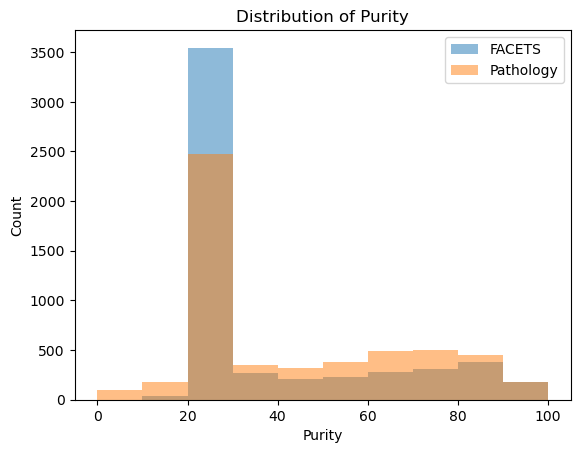

In [4]:
facetsList = facetsFileA.iloc[:, 1]
pathologyList = fileA.iloc[:, 1]
bins = [0,10,20,30,40,50,60,70,80,90,100]
plt.figure()
plt.hist(facetsList, bins = bins, alpha = 0.5, label = 'FACETS')
plt.hist(pathologyList, bins = bins, alpha = 0.5, label = 'Pathology')
plt.title("Distribution of Purity")
plt.ylabel("Count")
plt.xlabel("Purity")
plt.legend()
plt.show()

### Calls Comparison

In [5]:
# Dictionary to track which samples/genes were called by pathology purity
pathology_score_exists = {}

for idx, row in pathology.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        string_to_hash = str(row['tumorSampleId']) + '_' + str(row['gene'])
        if string_to_hash not in pathology_score_exists :
            pathology_score_exists[string_to_hash] = idx
        

In [6]:
# Dictionary to track which samples/genes were called by facets purity
facets_score_exists = {}

# Holds the actual scores to plot
score_pathology = []
score_facets = []

# Tally up
called_only_in_facets = 0
called_only_in_pathology = 0

for idx, row in facets.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        to_check = row['tumorSampleId'] + '_' + str(row['gene'])
        if to_check not in facets_score_exists :
            facets_score_exists[to_check] = idx
            if to_check in pathology_score_exists :
                score_pathology.append(pathology.loc[pathology_score_exists[to_check], 'ecDNA_prob'])
                score_facets.append(row['ecDNA_prob'])                    
            else :
                called_only_in_facets += 1

called_only_in_pathology = len(pathology_score_exists) - len(score_pathology)

print(f"Called only in FACETS: {called_only_in_facets}")
print(f"Called only in pathology: {called_only_in_pathology}")
print(f"Called in both: {len(facets_score_exists) - called_only_in_facets}")


Called only in FACETS: 3889
Called only in pathology: 4147
Called in both: 2669


Text(0.5, 1.0, 'ecDNA Probability for both FACETS and Pathology Called Genes')

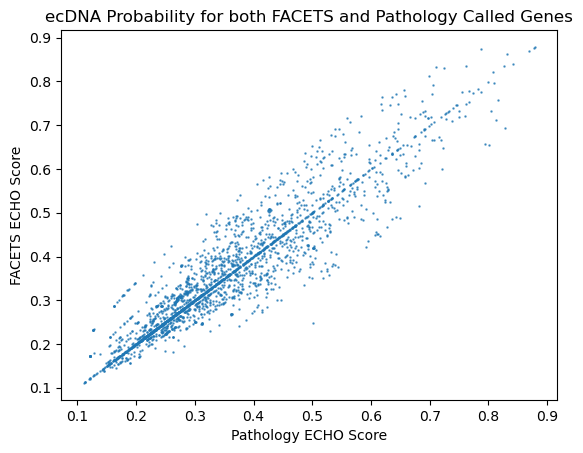

In [7]:
plt.scatter(score_pathology, score_facets, alpha = 0.7, s = 0.6)
plt.xlabel("Pathology ECHO Score")
plt.ylabel("FACETS ECHO Score")
plt.title("ecDNA Probability for both FACETS and Pathology Called Genes")

In [8]:
# Tally up
called_ecDNA_in_both = 0
called_ecDNA_in_facets = 0
called_ecDNA_in_pathology = 0

# Iterate through and count
for called in pathology_score_exists :
    if pathology.loc[pathology_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in facets_score_exists :
            if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_both += 1
            else :
                called_ecDNA_in_pathology += 1
        else :
            called_ecDNA_in_pathology += 1

for called in facets_score_exists :
    if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in pathology_score_exists :
            if not facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_facets += 1
        else :
            called_ecDNA_in_facets += 1

print(f"Both ecDNA: {called_ecDNA_in_both}")
print(f"Only ecDNA in FACETS purity: {called_ecDNA_in_facets}")
print(f"Only ecDNA in Pathology: {called_ecDNA_in_pathology}")

Both ecDNA: 283
Only ecDNA in FACETS purity: 10
Only ecDNA in Pathology: 85


### Does Purity Effect Calls?

In [9]:
# Dictionaries that connect sampleIds to the purity calls
facets_purity = {}
pathology_purity = {}

for i, row in facetsFileA.iterrows() :
    facets_purity[row['sampleId']] = row['purity']

for i, row in fileA.iterrows() :
    pathology_purity[row['sampleId']] = row['tumorPurity']

Text(0, 0.5, 'Pathology Purity')

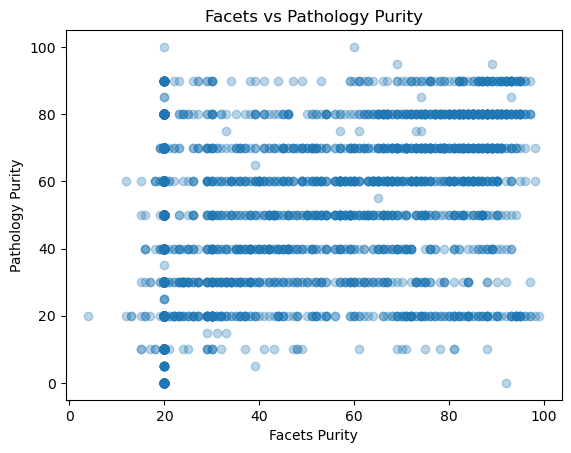

In [10]:
# Plot just the purities
plt.scatter(facetsFileA['purity'], fileA['tumorPurity'], alpha = 0.3)
plt.title("Facets vs Pathology Purity")
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")

Getting rid of default values

In [11]:
facetsNoDefault = facetsFileA[facetsFileA['purity'] != 20]
pathologyNoDefault = fileA[fileA['tumorPurity'] != 20]

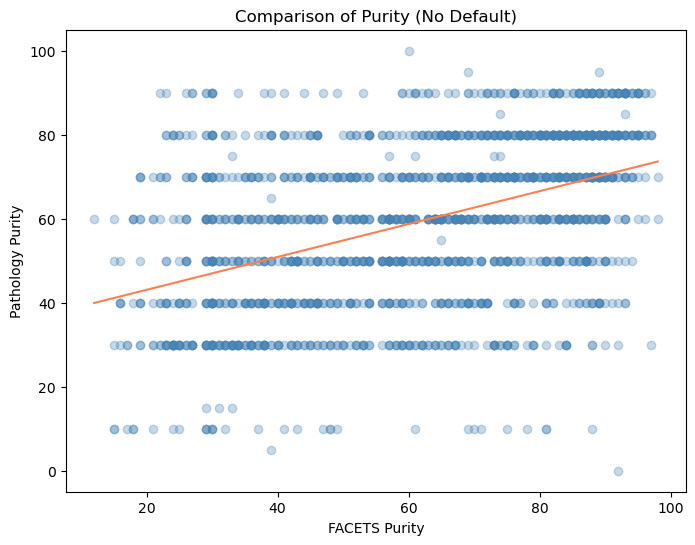

In [12]:
from scipy.stats import linregress
from scipy.optimize import curve_fit


merged = pd.merge(facetsNoDefault, pathologyNoDefault, left_on = 'sampleId', right_on = 'sampleId', how = 'inner')

plt.figure(figsize=(8, 6))
plt.scatter(merged['purity'], merged['tumorPurity'], alpha = 0.3, color = 'steelblue')

# Linear regression line
slope, intercept, r_value, p_value, std_err = linregress(merged['purity'], merged['tumorPurity'])
x_values = np.linspace(merged['purity'].min(), merged['purity'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, label=f'Linear Regression (R={r_value:.2f})', color='coral')
plt.title("Comparison of Purity (No Default)")
plt.xlabel("FACETS Purity")
plt.ylabel("Pathology Purity")
plt.savefig("puritycomp.png")

In [13]:
# Track the samples which have amplifiactions of some kind in pathology
has_pathology_amplifications = {}
for idx, row in pathology.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        has_pathology_amplifications[row['tumorSampleId']] = True

# Same for facets
has_facets_amplifications = {}

# These track the purities for samples only called amplified in facets
facets_only_facets = []
facets_only_pathology = []

# Iterate and fill
for idx, row in facets.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        has_facets_amplifications[row['tumorSampleId']] = True
       
for i in has_facets_amplifications :
    if not i in has_pathology_amplifications :
        facets_only_facets.append(int(facets_purity[i]))
        facets_only_pathology.append(int(pathology_purity[i]))

In [14]:
# Track purities for samples only called amplified in pathology
pathology_only_facets = []
pathology_only_pathology = []

for i in has_pathology_amplifications :
    if not i in has_facets_amplifications :
        pathology_only_facets.append(int(facets_purity[i]))
        pathology_only_pathology.append(int(pathology_purity[i]))

In [15]:
both_facets = []
both_pathology = []

for i in has_pathology_amplifications :
    if i in has_facets_amplifications :
        both_facets.append(int(facets_purity[i]))
        both_pathology.append(int(pathology_purity[i]))

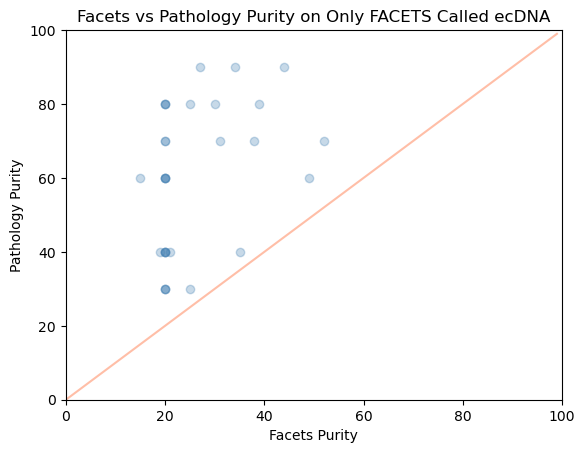

In [16]:
plt.scatter(facets_only_facets, facets_only_pathology, alpha = 0.3, color = 'steelblue')
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")
plt.title("Facets vs Pathology Purity on Only FACETS Called ecDNA")
x = np.arange(0,100)
plt.plot(x, x, color='coral', linestyle='-', alpha = 0.5)
plt.savefig('facets.pdf')

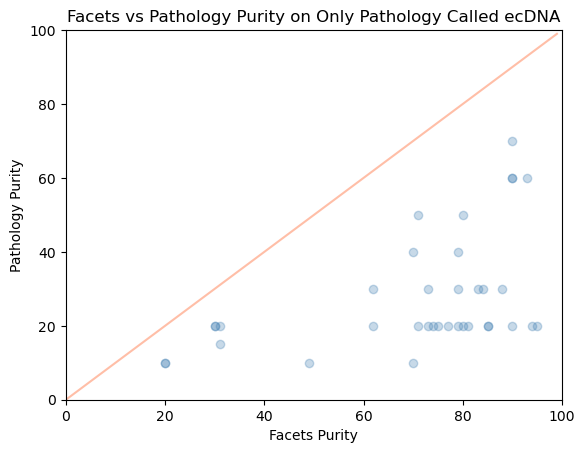

In [17]:
plt.scatter(pathology_only_facets, pathology_only_pathology, alpha = 0.3, color = 'steelblue')
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")
plt.title("Facets vs Pathology Purity on Only Pathology Called ecDNA")
x = np.arange(0,100)
plt.plot(x, x, color='coral', linestyle='-', alpha = 0.5)

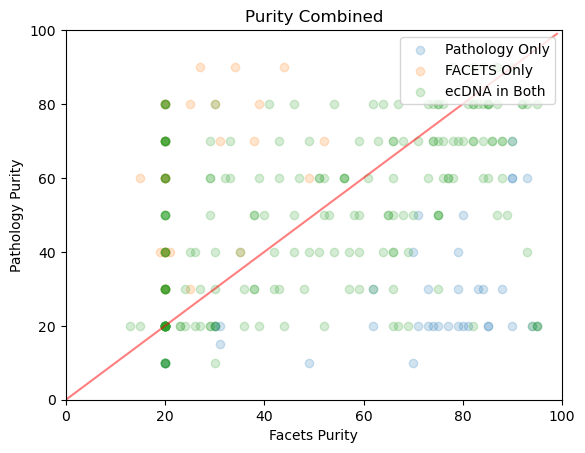

In [18]:
plt.scatter(pathology_only_facets, pathology_only_pathology, alpha = 0.2, label = "Pathology Only")
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")
plt.title("Purity Combined")
x = np.arange(0,100)
plt.plot(x, x, color='red', linestyle='-', alpha = 0.5)

plt.scatter(facets_only_facets, facets_only_pathology, alpha = 0.2, label = "FACETS Only")
plt.scatter(both_facets, both_pathology, alpha = 0.2, label = "ecDNA in Both")
plt.legend(loc = "upper right")

In [19]:
len(pathology_only_pathology)

36

In [20]:
len(facets_only_facets)

31

In [21]:
len(has_pathology_amplifications)

245

In [22]:
len(has_facets_amplifications)

240

In [23]:
overlap = 0
other = 0
for key in has_pathology_amplifications :
    if key in has_facets_amplifications :
        overlap += 1
    else :
        print(key)
        other += 1
print(overlap)
print(other)

P-0000883-T02-IM5
P-0006113-T02-IM6
P-0006215-T03-IM6
P-0006514-T01-IM5
P-0011220-T01-IM5
P-0017418-T02-IM6
P-0018116-T01-IM6
P-0018318-T01-IM6
P-0023805-T05-IM6
P-0024596-T01-IM6
P-0025639-T01-IM6
P-0026429-T01-IM6
P-0028301-T01-IM6
P-0037136-T02-IM6
P-0038948-T02-IM6
P-0043051-T04-IM7
P-0043051-T05-IM7
P-0045903-T03-IM7
P-0050144-T01-IM6
P-0051462-T01-IM6
P-0051680-T01-IM6
P-0052380-T01-IM6
P-0054022-T01-IM6
P-0054804-T02-IM6
P-0055056-T02-IM7
P-0056068-T04-IM7
P-0058155-T01-IM6
P-0068743-T07-IM7
P-0081706-T01-IM7
P-0085156-T04-IM7
P-0086354-T04-IM7
P-0086740-T01-IM7
P-0087641-T01-IM7
P-0088316-T01-IM7
P-0089144-T01-IM7
P-0093183-T01-IM7
209
36


In [24]:
overlap = 0
other = 0
for key in has_facets_amplifications :
    if key in has_pathology_amplifications :
        overlap += 1
    else :
        other += 1
print(overlap)
print(other)

209
31


In [25]:
specific_gene_pathology = {}
for i, row in pathology.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        key = row['gene'] + '_' + row['tumorSampleId']
        specific_gene_pathology[key] = True

specific_gene_facets = {}
for i, row in facets.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        key = row['gene'] + '_' + row['tumorSampleId']
        specific_gene_facets[key] = True

only_in_facets = 0
only_in_path = 0
in_both = 0
for key in specific_gene_facets :
    if key in specific_gene_pathology :
        in_both += 1
    else :
        only_in_facets += 1
        
only_in_path = len(specific_gene_pathology) - in_both

print(only_in_facets)
print(only_in_path)
print(in_both)

85
90
291
